In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [11]:
import os
# data = '/content/drive/MyDrive/brain_tumor/brain_tumor_dataset'
No_brain_tumor = 'C:/Users/Ankit/Downloads/no_tumor'
Yes_brain_tumor = 'C:/Users/Ankit/Downloads/pituitary_tumor'

In [3]:
#No_brain_tumor = '/content/drive/MyDrive/brain_tumor/no_tumor'
#Yes_brain_tumor = '/content/drive/MyDrive/brain_tumor/pituitary_tumor'

In [4]:
# os.listdir('/content/drive/MyDrive/brain_tumor')

In [12]:
dir_list = [No_brain_tumor, Yes_brain_tumor]
classes = ['no', 'yes']
filepaths = []
labels = []

for i,j in zip(dir_list, classes):
    filelist = os.listdir(i)
    for name in filelist:
        filepath = os.path.join(i, name)
        filepaths.append(filepath)
        labels.append(j)
        
print('filepaths:', len(filepaths), 'labels:', len(labels))

filepaths: 1223 labels: 1223


In [13]:
file_content=pd.Series(filepaths, name='filepaths')
label_content=pd.Series(labels, name='labels')
df=pd.concat([file_content,label_content], axis=1)
df.shape
#df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
#df.shape

(1223, 2)

In [15]:
!pip3 install opencv-python

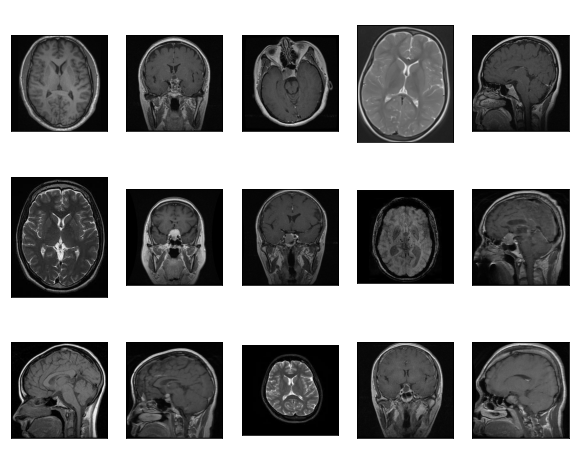

In [32]:
#visualize brain tumor images
import cv2

plt.figure(figsize=(10,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()


In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

print(f"train set shape: {x_train.shape}")
print(f"test set shape: {x_test.shape}")
print(f"validation set shape: {x_val.shape}")

train set shape: (782, 2)
test set shape: (245, 2)
validation set shape: (196, 2)


In [34]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode ='nearest')

validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [35]:
train_generator = train_datagen.flow_from_dataframe(dataframe = x_train,
                                                   x_col = 'filepaths',
                                                   y_col = 'labels',
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size=16)

validation_generator = validation_datagen.flow_from_dataframe(dataframe = x_val,
                                                             x_col = 'filepaths',
                                                             y_col = 'labels',
                                                             target_size = (150,150),
                                                             class_mode='binary',
                                                             batch_size=8)

test_generator = test_datagen.flow_from_dataframe(dataframe = x_test,
                                                  x_col = 'filepaths',
                                                  y_col = 'labels',
                                                  target_size = (150,150),
                                                  class_mode='binary',
                                                  batch_size=8)

Found 782 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.
Found 245 validated image filenames belonging to 2 classes.


In [49]:
# base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', 
#                                                      input_shape = (150,150,3),
#                                                      include_top=False)


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(150,150,3)))

model.add(tf.keras.layers.Conv2D(98, kernel_size=(3,3), activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3)))

model.add(tf.keras.layers.Conv2D(49, kernel_size=(3,3), strides=1,  activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3)))
# model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 98)      2744      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 98)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 49)        43267     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 49)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 11025)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)             

In [50]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])


In [51]:
history = model.fit(train_generator,epochs=30,steps_per_epoch=10,validation_data = validation_generator,validation_steps=6,verbose=1)

Epoch 1/30
10/10 [==============================] - 9s 868ms/step - loss: 0.6798 - accuracy: 0.6250 - val_loss: 0.5713 - val_accuracy: 0.7917
Epoch 2/30
10/10 [==============================] - 10s 983ms/step - loss: 0.6671 - accuracy: 0.6875 - val_loss: 0.6516 - val_accuracy: 0.6667
Epoch 3/30
10/10 [==============================] - 9s 817ms/step - loss: 0.6338 - accuracy: 0.7000 - val_loss: 0.6852 - val_accuracy: 0.6667
Epoch 4/30
10/10 [==============================] - 9s 872ms/step - loss: 0.6648 - accuracy: 0.6812 - val_loss: 0.6214 - val_accuracy: 0.7500
Epoch 5/30
10/10 [==============================] - 8s 791ms/step - loss: 0.6411 - accuracy: 0.6562 - val_loss: 0.6736 - val_accuracy: 0.6250
Epoch 6/30
10/10 [==============================] - 9s 862ms/step - loss: 0.6588 - accuracy: 0.6687 - val_loss: 0.6206 - val_accuracy: 0.7292
Epoch 7/30
10/10 [==============================] - 9s 831ms/step - loss: 0.6191 - accuracy: 0.7188 - val_loss: 0.6547 - val_accuracy: 0.7083
Epoch

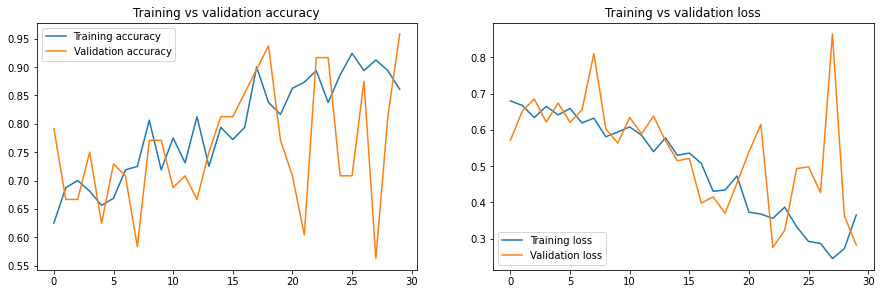

In [52]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
test_accuracy = model.evaluate(test_generator)[1]


In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("\n The Classification report is \n")
print(classification_report(x_test.labels, y_pred))
print("\n The Confusion Matrix is \n")
print(confusion_matrix(x_test.labels, y_pred))